In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
BASE_PATH = "/kaggle/input/asl-signs"

train_csv = pd.read_csv(f"{BASE_PATH}/train.csv")
with open(f"{BASE_PATH}/sign_to_prediction_index_map.json", "r") as f:
    label_map = json.load(f)

NUM_CLASSES = len(label_map)
print("Classes:", NUM_CLASSES)


Classes: 250


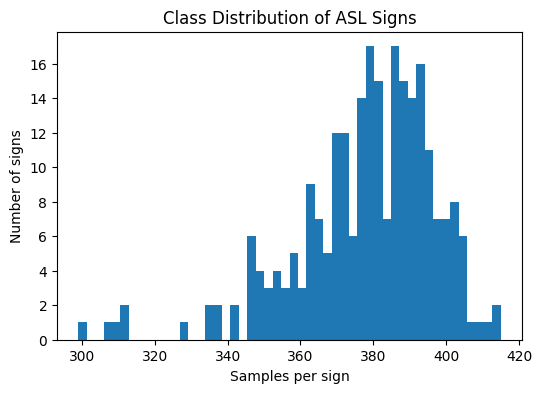

In [4]:
#Each ASL sign (word) in the dataset is treated as a separate class.
#This plot shows how many training examples are available for each sign.

#X-axis (Samples per sign):
#How many times a particular ASL sign appears in the dataset.

#Y-axis (Number of signs):
#How many different signs fall into that sample-count range.

class_counts = train_csv["sign"].value_counts()

plt.figure(figsize=(6,4))
plt.hist(class_counts.values, bins=50)
plt.xlabel("Samples per sign")
plt.ylabel("Number of signs")
plt.title("Class Distribution of ASL Signs")
plt.show()


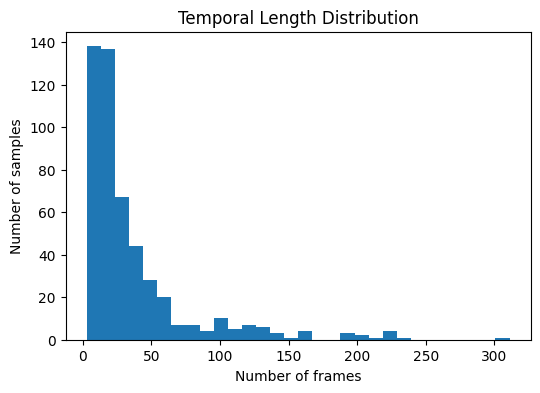

In [5]:
frame_counts = []

for path in train_csv["path"][:500]:  # subset for speed
    df = pd.read_parquet(f"{BASE_PATH}/{path}", columns=["frame"])
    frame_counts.append(df["frame"].nunique())

plt.figure(figsize=(6,4))
plt.hist(frame_counts, bins=30)
plt.xlabel("Number of frames")
plt.ylabel("Number of samples")
plt.title("Temporal Length Distribution")
plt.show()


In [7]:
from joblib import Parallel, delayed
import pandas as pd
import os

N_JOBS = 4  # optimal for Kaggle

def has_valid_hands_fast(sample_path, min_frames=5):
    full_path = os.path.join(BASE_PATH, sample_path)

    df = pd.read_parquet(
        full_path,
        columns=["frame", "type"],
        engine="pyarrow"
    )

    hand_df = df[df["type"].isin(["left_hand", "right_hand"])]

    if hand_df.empty:
        return False

    if hand_df["frame"].nunique() < min_frames:
        return False

    return True



def check_index(i):
    return i if has_valid_hands_fast(train_csv.iloc[i]["path"]) else None

In [ ]:
print("Fast filtering (optimized)...")

results = Parallel(
    n_jobs=N_JOBS,
    prefer="threads"
)(
    delayed(check_index)(i) for i in range(len(train_csv))
)

valid_indices = [i for i in results if i is not None]

print(f"Valid samples: {len(valid_indices)} / {len(train_csv)}")

In [ ]:
# Save once
np.save("/kaggle/working/valid_indices.npy", np.array(valid_indices))


In [8]:
# Load instead of recomputing
valid_indices = np.load("/kaggle/input/valid-indices-npy/valid_indices.npy").tolist()

In [11]:
def load_hand_keypoints(sample_path):
    full_path = os.path.join(BASE_PATH, sample_path)
    df = pd.read_parquet(full_path, engine="pyarrow")

    hand_df = df[df["type"].isin(["left_hand", "right_hand"])]

    # Ensure ordering
    hand_df = hand_df.sort_values(["frame", "type", "landmark_index"])

    frames = hand_df["frame"].nunique()

    coords = hand_df[["x", "y", "z"]].values
    coords = coords.reshape(frames, 42, 3)

    coords = np.nan_to_num(coords, nan=0.0)
    return coords


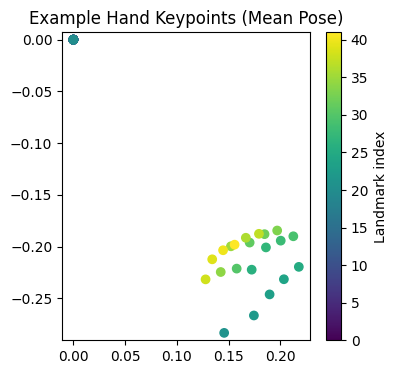

In [13]:
#Each dot represents one hand joint (for example: wrist, finger joints).
#The color indicates the index of the joint (different joints are colored differently).

#The plot shows the average hand position over time for one signing instance.

#In simple terms:
#This is the average shape of the hand while a person was signing a word.

# Load one sample
kp = load_hand_keypoints(train_csv.iloc[0]["path"])  # (T, 42, 3)

# Temporal mean pooling (Tier-1 input)
kp_mean = kp.mean(axis=0)  # (42, 3)

# Plot
plt.figure(figsize=(4,4))
plt.scatter(kp_mean[:,0], -kp_mean[:,1], c=range(42), cmap="viridis")
plt.colorbar(label="Landmark index")
plt.title("Example Hand Keypoints (Mean Pose)")
plt.axis("equal")
plt.show()


In [14]:
train_csv = train_csv.iloc[valid_indices].reset_index(drop=True)


In [15]:
print("train_csv length:", len(train_csv))
train_csv.head()


train_csv length: 94198


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [16]:
df = pd.read_parquet(f"{BASE_PATH}/{train_csv.iloc[0]['path']}")
df.head(10)


,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
5,20,20-face-5,face,5,0.496499,0.330019,-0.056744
6,20,20-face-6,face,6,0.501039,0.301457,-0.028559
7,20,20-face-7,face,7,0.436136,0.306364,0.032783
8,20,20-face-8,face,8,0.501792,0.282995,-0.021999
9,20,20-face-9,face,9,0.501045,0.271745,-0.024336


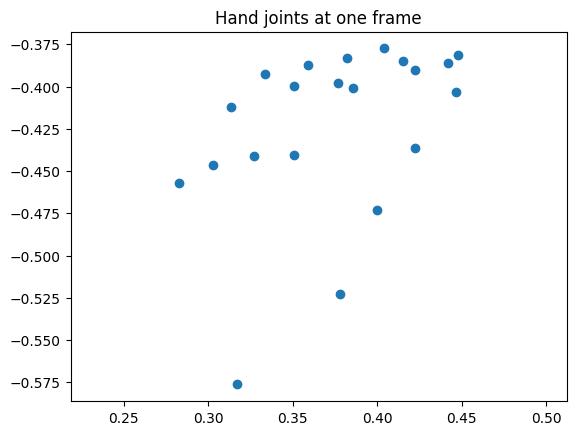

In [18]:
hand_df = df[df["type"].isin(["left_hand", "right_hand"])]

frame0 = hand_df[hand_df["frame"] == hand_df["frame"].min()]

plt.scatter(frame0["x"], -frame0["y"])
plt.title("Hand joints at one frame")
plt.axis("equal")
plt.show()


In [19]:
class ASLKeypointDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        keypoints = load_hand_keypoints(row["path"])  # (T, 42, 3)
        label = label_map[row["sign"]]

        keypoints = torch.tensor(keypoints, dtype=torch.float32)

        # 🔥 TEMPORAL POOLING FOR TIER-1
        keypoints = keypoints.mean(dim=0)  # (42, 3)

        return keypoints, label


In [20]:
def spatial_complexity(kp):
    # kp: (T, J, 3)
    return kp.var(dim=1).mean().item()

def temporal_complexity(kp):
    velocity = kp[1:] - kp[:-1]
    return velocity.var().item()

def shape_diversity(kp):
    flat = kp.reshape(kp.shape[0], -1)
    return flat.var(dim=0).mean().item()


In [13]:
import numpy as np
from tqdm import tqdm

spatial_vals = []
temporal_vals = []
diversity_vals = []

print("Computing difficulty statistics (optimized)...")

for i in tqdm(range(len(train_csv))):
    kp = load_hand_keypoints(train_csv.iloc[i]["path"])  # numpy array (T, 42, 3)

    # --- Spatial complexity ---
    spatial = np.var(kp, axis=1).mean()

    # --- Temporal complexity ---
    if kp.shape[0] > 1:
        velocity = kp[1:] - kp[:-1]
        temporal = np.var(velocity)
    else:
        temporal = 0.0

    # --- Shape diversity ---
    flat = kp.reshape(kp.shape[0], -1)
    diversity = np.var(flat, axis=0).mean()

    spatial_vals.append(spatial)
    temporal_vals.append(temporal)
    diversity_vals.append(diversity)

stats = {
    "spatial": (np.min(spatial_vals), np.max(spatial_vals)),
    "temporal": (np.min(temporal_vals), np.max(temporal_vals)),
    "diversity": (np.min(diversity_vals), np.max(diversity_vals)),
}

print("Difficulty stats computed.")


Computing difficulty statistics (optimized)...


100%|██████████| 94198/94198 [40:06<00:00, 39.15it/s]  

Difficulty stats computed.


In [14]:
np.save("/kaggle/working/spatial_vals.npy", spatial_vals)
np.save("/kaggle/working/temporal_vals.npy", temporal_vals)
np.save("/kaggle/working/diversity_vals.npy", diversity_vals)


In [21]:
spatial_vals = np.load("/kaggle/input/valid-indices-npy/spatial_vals.npy")
temporal_vals = np.load("/kaggle/input/valid-indices-npy/temporal_vals.npy")
diversity_vals = np.load("/kaggle/input/valid-indices-npy/diversity_vals.npy")


In [23]:
def normalize(x, min_v, max_v):
    return (x - min_v) / (max_v - min_v + 1e-8)


In [24]:
spatial_norm = normalize(spatial_vals, *stats["spatial"])
temporal_norm = normalize(temporal_vals, *stats["temporal"])
diversity_norm = normalize(diversity_vals, *stats["diversity"])


NameError: name 'stats' is not defined

In [20]:
difficulties = (
    0.25 * spatial_norm +
    0.40 * temporal_norm +
    0.35 * diversity_norm
)


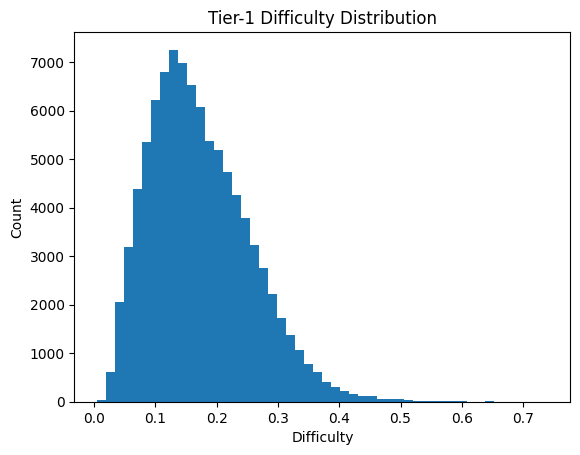

In [21]:
import matplotlib.pyplot as plt

plt.hist(difficulties, bins=50)
plt.title("Tier-1 Difficulty Distribution")
plt.xlabel("Difficulty")
plt.ylabel("Count")
plt.show()


In [22]:
np.save("/kaggle/working/difficulties.npy", difficulties)


In [23]:
difficulties = np.load("/kaggle/input/valid-indices-npy/difficulties.npy")
easy_thr = np.quantile(difficulties, 0.33)
hard_thr = np.quantile(difficulties, 0.66)

In [24]:
def difficulty_init(kp):
    s = normalize(spatial_complexity(kp), *stats["spatial"])
    t = normalize(temporal_complexity(kp), *stats["temporal"])
    d = normalize(shape_diversity(kp), *stats["diversity"])

    return 0.25*s + 0.40*t + 0.35*d


In [56]:
import numpy as np
from tqdm import tqdm

X = []
y = []

print("Precomputing Tier-1 features...")

for i in tqdm(range(len(train_csv))):
    kp = load_hand_keypoints(train_csv.iloc[i]["path"])  # (T, 42, 3)
    kp_static = kp.mean(axis=0)                          # (42, 3)

    X.append(kp_static.astype(np.float32))
    y.append(label_map[train_csv.iloc[i]["sign"]])

X = np.stack(X)   # (N, 42, 3)
y = np.array(y)

np.save("/kaggle/working/X_tier1.npy", X)
np.save("/kaggle/working/y_tier1.npy", y)

print("Saved Tier-1 features.")


Precomputing Tier-1 features...


 29%|██▉       | 27774/94198 [08:58<21:28, 51.54it/s]


KeyboardInterrupt: 

In [54]:
class Tier1CachedDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
X = np.load("/kaggle/working/X_tier1.npy")
y = np.load("/kaggle/working/y_tier1.npy")


In [51]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = Tier1CachedDataset(X_train, y_train)
val_ds   = Tier1CachedDataset(X_val, y_val)


In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [36]:
num_classes = train_csv["sign"].nunique()
print("Number of classes:", num_classes)


Number of classes: 250


In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [52]:
from tqdm import tqdm
import torch.nn as nn

def train_one_seed(seed, num_classes, device, num_epochs):
    set_seed(seed)

    model = Tier1Model(num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        loop = tqdm(
            train_loader,
            desc=f"Seed {seed} | Epoch {epoch+1}/{num_epochs}",
            mininterval=1.0,
            leave=False
        )

        for x, y in loop:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} | Avg Loss: {epoch_loss/len(train_loader):.4f}")

    return model


In [53]:
SEEDS = [42, 123, 999]
num_epochs = 20
num_classes = len(np.unique(y))

results = []

for seed in SEEDS:
    print(f"\nTraining with seed {seed}")
    model = train_one_seed(seed, num_classes, device, num_epochs)
    acc, f1 = evaluate(model, val_loader)
    results.append((acc, f1))

results



Training with seed 42


KeyboardInterrupt: 

In [28]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()

            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1


In [ ]:
accs = [r[0] for r in results]
f1s = [r[1] for r in results]

print(f"Macro Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Macro F1:       {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


In [ ]:
def compute_confidence(logits):
    probs = torch.softmax(logits, dim=1)
    return probs.max(dim=1).values


In [ ]:
model.eval()
confidences, correct = [], []
device = "cuda" if torch.cuda.is_available() else "cpu"
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        conf = compute_confidence(logits)
        preds = logits.argmax(dim=1)

        confidences.extend(conf.numpy())
        correct.extend((preds == y).numpy())

confidences = np.array(confidences)
correct = np.array(correct)

thresholds = np.linspace(0.5, 0.95, 20)
for t in thresholds:
    mask = confidences > t
    if mask.sum() < 100:
        continue
    acc = correct[mask].mean()
    print(f"Threshold {t:.2f} | Coverage {mask.mean():.2f} | Accuracy {acc:.3f}")


In [ ]:
import numpy as np
import torch

model.eval()
device = next(model.parameters()).device

all_conf = []
all_preds = []
all_labels = []
all_logits = []   # IMPORTANT: needed for Top-K

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)                      # (B, C)
        probs = torch.softmax(logits, dim=1)

        conf = probs.max(dim=1).values         # confidence
        preds = probs.argmax(dim=1)

        all_conf.append(conf.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())
        all_logits.append(logits.cpu())

# concatenate
all_conf = torch.cat(all_conf).numpy()
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
all_logits = torch.cat(all_logits)  # keep as torch tensor

print("Validation samples collected:", len(all_conf))


In [ ]:
thresholds = np.linspace(0.02, 0.30, 25)

coverages = []

for t in thresholds:
    exit_mask = all_conf >= t
    coverages.append(exit_mask.mean())

coverages = np.array(coverages)


In [ ]:
# METRIC 1: Top-K Accuracy
def topk_accuracy(logits, labels, k=5):
    """
    logits: (N, C)
    labels: (N,)
    """
    topk = logits.topk(k, dim=1).indices
    labels = labels.unsqueeze(1)
    return (topk == labels).any(dim=1).float()


In [ ]:
top5_accs = []

for t in thresholds:
    exit_mask = all_conf >= t

    if exit_mask.sum() == 0:
        top5_accs.append(np.nan)
        continue

    logits_exited = all_logits[exit_mask]
    labels_exited = torch.tensor(all_labels[exit_mask])

    acc5 = topk_accuracy(logits_exited, labels_exited, k=5).mean().item()
    top5_accs.append(acc5)

top5_accs = np.array(top5_accs)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(coverages, top5_accs, marker="o")
plt.xlabel("Coverage (fraction exited at Tier-1)")
plt.ylabel("Top-5 Accuracy on exited samples")
plt.title("Tier-1 Early Exit: Coverage vs Top-5 Accuracy")
plt.grid(True)
plt.tight_layout()

plt.savefig("tier1_coverage_vs_top5_accuracy.png", dpi=300)
plt.show()


In [ ]:
# Metric 2: Confidence Entropy
entropies = []

with torch.no_grad():
    probs = torch.softmax(all_logits, dim=1)
    entropy = -(probs * torch.log(probs + 1e-9)).sum(dim=1)

entropies = entropy.numpy()


In [ ]:
avg_entropy = []

for t in thresholds:
    exit_mask = all_conf >= t

    if exit_mask.sum() == 0:
        avg_entropy.append(np.nan)
    else:
        avg_entropy.append(entropies[exit_mask].mean())

avg_entropy = np.array(avg_entropy)

plt.figure(figsize=(7, 5))
plt.plot(coverages, avg_entropy, marker="o")
plt.xlabel("Coverage")
plt.ylabel("Average Entropy (Exited Samples)")
plt.title("Tier-1 Exit Confidence: Coverage vs Entropy")
plt.grid(True)
plt.tight_layout()

plt.savefig("tier1_coverage_vs_entropy.png", dpi=300)
plt.show()


In [ ]:
# Metric 3: Selective Risk
from sklearn.metrics import accuracy_score

risks = []

for t in thresholds:
    exit_mask = all_conf >= t

    if exit_mask.sum() == 0:
        risks.append(np.nan)
    else:
        acc = accuracy_score(
            all_labels[exit_mask],
            all_preds[exit_mask]
        )
        risks.append(1.0 - acc)

risks = np.array(risks)


In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(coverages, risks, marker="o")
plt.xlabel("Coverage")
plt.ylabel("Selective Risk")
plt.title("Tier-1 Early Exit: Risk vs Coverage")
plt.grid(True)
plt.tight_layout()

plt.savefig("tier1_risk_vs_coverage.png", dpi=300)
plt.show()
